# Coding Exercises from Machine Learning (Andrew Ng)

## Set 1 Problem 2: Locally Weighted Regression


*In this problem you will implement a locally-weigthed version of logistica regression, where we weight different training examples according to the query point. The locally-weighted logistic regression problem is to maximize:*

$$ l(\theta) = -\lambda/2 \theta^T \theta + \sum_{i=0}^m w^{(i)} [ y^{(i)} log (h_{\theta} (x^{(i)})) + (1-y^{(i)}) log(1-h_\theta (x^{(i)})))] $$

$$ h_{\theta} (x^{(i)}) = \frac{1}{1+exp(-\theta^T x^{(i)})} $$

*We need the regularization parameter for Netwon's method to work well here. We'll set it really low (0.0001).*







*(a) Implement Newton-Raphson Method for optimizing l(theta) for a new query point and predict the class of x. *



In [1]:
import scipy as sp
from sklearn import datasets
import matplotlib.pyplot as plt 
import numpy as np
from IPython.core.debugger import Tracer


%matplotlib inline

In [2]:
iris = datasets.load_iris()

In [3]:
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

# limit to y=0 or 1
X_train = X[y!=2]
y_train = y[y!=2]

X_train = X_train.astype('float')
y_train = y_train.astype('float')

# x new is
x_new = np.array([5.3,3.0])
y_new = 1.0

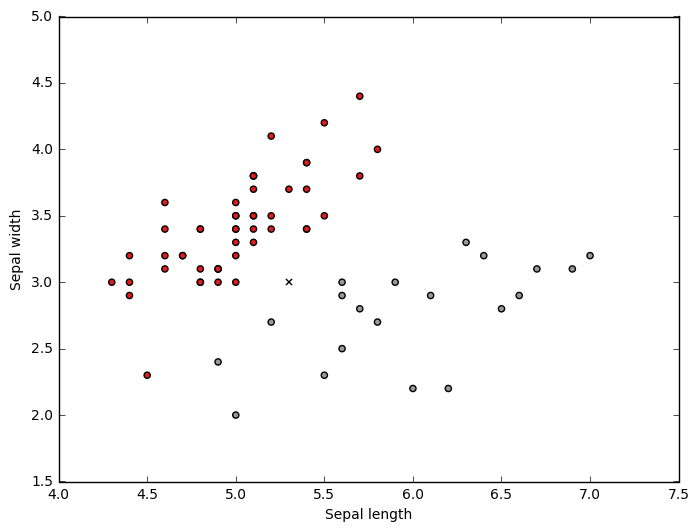

In [4]:
plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X_train[0:70, 0], X_train[0:70, 1], c=y_train[0:70], cmap=plt.cm.Set1,
            edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.scatter(x_new[0], x_new[1], c='k', marker='x',cmap=plt.cm.Set1,
            edgecolor='k')

*a1) compute weights w^(i) for x query for each training example (w is column vect)*

*For query point x, we use the local weighting function:*

$$ w^{(i)}=exp(||x-x^{(i)}||^2 / 2 \tau^2) $$ 


In [5]:
def w_(X_train,x_new,tau=1.0):
    w = np.zeros((X_train.shape[0]))
    for i in range(X_train.shape[0]):
        xi = X_train[i,:]
        w[i] = np.exp(-1.0*(np.sum((xi-x_new)**2)/(2.0*tau)))
    return(w)

w = w_(X_train,x_new)
print(x_new)
print(w[0:5])
print(X_train[0:5,:])

[ 5.3  3. ]
[ 0.86502229  0.92311635  0.81873075  0.77880078  0.79851622]
[[ 5.1  3.5]
 [ 4.9  3. ]
 [ 4.7  3.2]
 [ 4.6  3.1]
 [ 5.   3.6]]


- w is a weight for each training example to see how close it is to the test example.  
- The test example was printed first, and then the weights and then the training examples. High weight are close by examples. 
- Maximizing the liklihood now will emphasize close by training examples to find theta. 

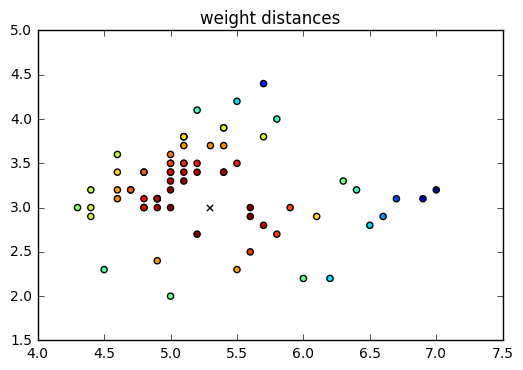

In [6]:
plt.scatter(X_train[0:70, 0], X_train[0:70, 1], c=w[0:70],
            edgecolor='k')
plt.title('weight distances')
plt.scatter(x_new[0], x_new[1], c='k', marker='x',cmap=plt.cm.Set1,
            edgecolor='k')

*a2) maximize loglik with Newton-Raphson Method*

$ \theta := \theta - H(l(\theta))^{-1} \nabla l(\theta) $

The gradient (1xp vector) is: 

$ \nabla l(\theta)=X^Tz-\lambda \theta $

Where:  

$ z_i = w^{(i)}(y^{(i)} - h_{\theta} (x^{(i)}) $

and the Hessian (pxp matrix) is: 

$ H = X^TDX - \lambda I $



Where D is: 

$ D_{ii} = -w^{(i)}h_{\theta} (x^{(i)})(1-h_{\theta} (x^{(i)})) $

In [7]:
def lwlr(X_train,y_train,x_new,tau=1.0,lambbda = 0.0001):


    # initialize theta 
    theta = np.zeros((X_train.shape[1],1))
    
    # calculate w 
    w = np.ones(X_train.shape[0])
    w = w_(X_train,x_new,tau=tau)
    
    # maximize 
    for step in range(50):
        
        #print(theta)
        theta_prev = theta.copy()

        # gradient 
        h = np.squeeze(1.0 / (1.0 + np.exp(-1.0*(np.dot(X_train,theta)))))
        z = w*(y_train-h)
        g = np.dot(X_train.T,z[:,np.newaxis])-theta*lambbda

        # Hessian 
        D = np.eye(X_train.shape[0])*w*h*(1.0-h)
        H = np.dot(-1.0*X_train.T,np.dot(D,X_train)) - lambbda*np.eye(X_train.shape[1])

        
        
        #Newton's Method (still a negative, which he mentioned)
        theta = theta - np.dot(np.linalg.inv(H),g)

        # Gradient ascescent, but this would be positive. 
        #theta = theta + 0.1*g

        
        # loglik # 
        l = w*(y_train*np.log(h+0.0001) + (1-y_train)*(np.log(1-h+0.0001)))
        ll = np.sum(l)-lambbda/2.0*np.dot(theta.T,theta)
        #print(np.linalg.norm(theta))
        #print(step)
        #print(ll)
        #print('ep: {0}').format(diff)
        #print()
    pred_y = np.squeeze(1.0 / (1.0 + np.exp(-1.0*(np.dot(x_new,theta)))))
    return(pred_y)

In [8]:
x_new = np.array([5.3,2.0])
lwlr(X_train,y_train,x_new,0.5)

array(0.9999832045105157)

In [9]:
x_new = np.array([4.0,5.0])
lwlr(X_train,y_train,x_new,0.5)

array(6.330048548748878e-14)

In [11]:
def make_meshgrid(x, y, h=.25):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    #Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    return out

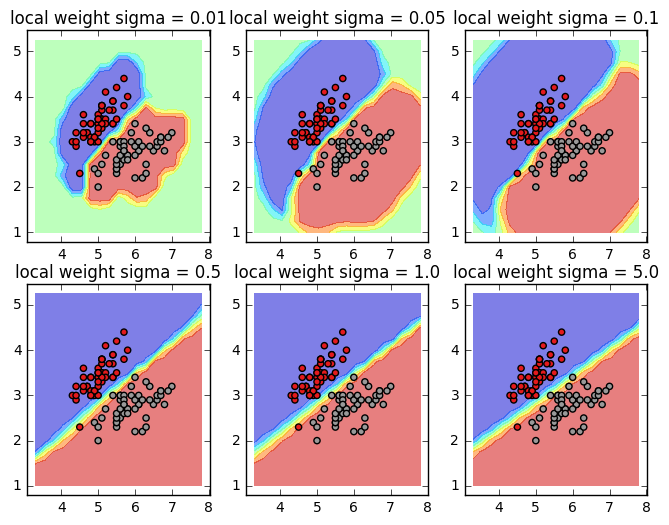

In [12]:
fig,axes = plt.subplots(2,3, figsize=(8, 6))
axes = axes.flatten()


for t,tau in enumerate([0.01,0.05,0.1,0.5,1.0,5.0]):

    # Separation Line
    X0, X1 = X_train[:, 0], X_train[:, 1]
    x0, x1 = make_meshgrid(X0, X1)
    grid_examples = np.c_[x0.ravel(), x1.ravel()]
    Z = np.empty(len(grid_examples))
    for i in range(len(grid_examples)):
        Z[i]= lwlr(X_train,y_train,grid_examples[i,:],tau=tau)
    Z = Z.reshape(x0.shape)
    axes[t].contourf(x0, x1, Z,alpha=0.5)

    # Plot the training points
    axes[t].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Set1,
                edgecolor='k')
    axes[t].set_title('local weight sigma = '+str(tau))
plt.show()

## Set 4 Problem 4: ICA and PCA 

- 

### Image Setup


In [258]:
import tensorflow as tf
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from tensorflow.examples.tutorials.mnist import input_data

In [264]:

# Loading the images using tensor flow's mnist dataset
mnist = input_data.read_data_sets("../data/MNIST_data/", one_hot=True)

# sub-sample to 1000 images? 
n_images = 10000
images_highres = mnist.train.images[0:n_images,:].reshape((n_images,28,28))

# down-sample resolution
images = np.empty((n_images,28,28))
for i in range(n_images):
    images[i,:,:] = sp.misc.imresize(images_highres[i,:,:],(28,28))
#images[np.isnan(images)]=0.0
        

Extracting ../data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [265]:

# reshape 
n_pixels = 28*28
x_pca = np.reshape(images,(n_images,28*28)).T
x_ica = np.reshape(images,(n_images,28*28)).T 
print(x_pca.shape)

(784, 10000)


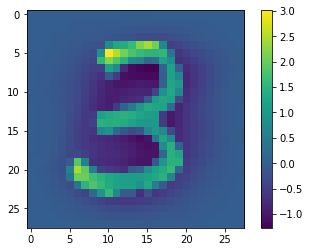

In [273]:
plt.imshow(np.reshape(x_pca,(28,28,n_images))[:,:,11])
plt.colorbar()

In [268]:
# normalize mean and variance for PCA
u = np.nanmean(x_pca,axis=1) # mean for each pixel 
sigma = np.nanstd(x_pca,axis=1) # varaiance for each pixel

for i in range(n_images):
    x_pca[:,i] = (x_pca[:,i]-u)/sigma

x_pca[np.isnan(x_pca)] = 0.0


/Users/chris/Desktop/virtenv_deeprl/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [269]:
# normalize mean for ICA
u = np.nanmean(x_ica,axis=1) # mean for each pixel 

for i in range(n_images):
    x_ica[:,i] = (x_ica[:,i]-u)



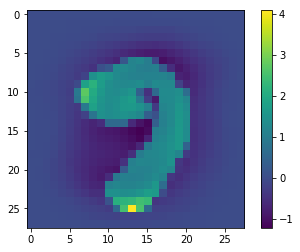

In [271]:
plt.imshow(np.reshape(x_pca,(28,28,n_images))[:,:,1100])
plt.colorbar()

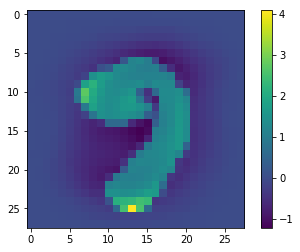

In [275]:
plt.imshow(np.reshape(x_ica,(28,28,n_images))[:,:,1100])
plt.colorbar()

### PCA

- differ's from factor analysis in that it does not assume a probablistic model (ie. z~norm, and then x created as x = \Lambda x + u), and tries to estimate the subspace directly
- requires finding the eigenvalues of the covariance matrix X. 

Implementation Option 1: 
- compute empirical covariance estimate $ \Sigma = 1/m X^TX $ (assume X is zero mean) 
- eigenvalue decompose $\Sigma U = \lambda U $, or $\Sigma = U^{-1} \lambda U $


In [276]:
# PCA implementation # 
def PCA(x_pca):
    n_images = np.shape(x_pca)[1]
    n_pixels = np.shape(x_pca)[0]

    # option 1:
    
    # compute covariance cov(X)
    Sigma = np.dot(x_pca,x_pca.T)
    
    # do eigenvalue decomp
    #D,U = np.linalg.eig(Sigma)
    #return(D,U)
    
    # option 2: SVD? 
    [U,S,V] = np.linalg.svd(Sigma)
    return(U,S,V)



In [277]:
U,S,V = PCA(x_pca)

In [278]:
x_pca.shape

(784, 10000)

In [279]:
#plt.plot(D)

In [280]:
U.shape

(784, 784)

In [281]:
#np.real(U[:,1])

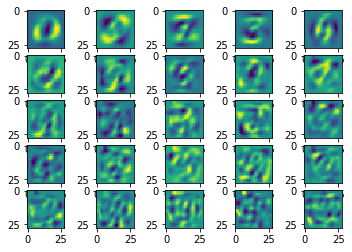

In [282]:
fig,axes=plt.subplots(5,5)
axes = axes.flatten()
for i in range(25):
    axes[i].imshow(np.reshape(np.real(U[:,i]),(28,28)))


### PCA Using SKLearn

In [283]:
import sklearn 
from sklearn.decomposition import PCA

In [284]:
x_pca.shape

(784, 10000)

In [285]:
pca = PCA(n_components=25)
pca.fit(x_pca.T)

PCA(copy=True, iterated_power='auto', n_components=25, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [286]:
pca.components_.shape

(25, 784)

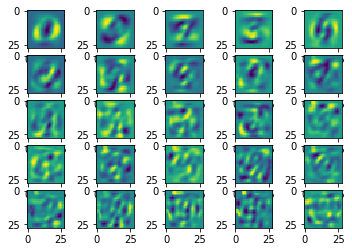

In [288]:
fig,axes=plt.subplots(5,5)
axes = axes.flatten()
for i in range(25):
    axes[i].imshow(np.reshape(pca.components_[i,:],(28,28)))


### ICA


Data Set up : 
- We assume that the the data x is compoased up of independnet sources.  $ X = AS $
- x is kxt (multiple microphones .. or in this case pixels)
- s is nxt (e.g. 2 sources by time or in this pixels) 
- A is kxn (256 x 256 here) and is called the mixing matrix 
- W is $ A^{-1} $, the unmixing matrix 
- We can only recover A up to some scalings and permutations
- requires data to be non-gaussian to recover n-independent sources

Probablistic Model: (using change of variables for multidimensional data) 
 

- $ p(s) = \prod_n p_s(s_i) $ assume independence
- $ p(x) = \prod_n p_s(w_i^T x_i) |W| $ change of variables
- specify cdf for s $ g(s) = 1 / 1+e^{-1s}) $
- gives us pdf as $g'(s)$ 
- $ log(W) = \sum_i \sum_j log(w_j^T x^i) + log(|W|) $ 

Leanring Algorithm:  (stochastic gradient descent)

For single training example i. 

- $ W:= W + \alpha [1-2g(w_1^Tx^i)...]x^i trans + [W^T]-1 $


**Need to white the data. That's probably why it's not working**

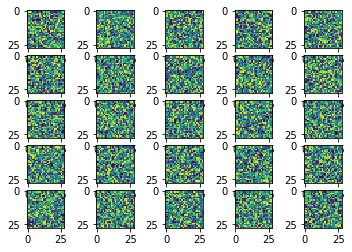

In [328]:
# initialize weights 
#W = np.eye(n_pixels,25) # let's assume sources and pixels are the same? 
W = np.random.random((n_pixels,25))
fig,axes=plt.subplots(5,5)
axes = axes.flatten()
for i in range(25):
    axes[i].imshow(np.reshape(W[:,i],(28,28)))


In [343]:

# initialize weights 
#W = np.eye(n_pixels,25) # let's assume sources and pixels are the same? 
W = np.random.random((n_pixels,25))
# 
alpha = 0.001

batchsize = 100

for step in range(1000): 
    indices = np.random.choice(n_images,batchsize)

    x_batch = x_pca[:,indices]

    # stochastic gradient descent
    g = np.squeeze((1.0-(2.0 / (1.0 + np.exp(-1.0*(np.dot(W.T,x_batch)))))))

    W = W + alpha*(np.dot(g,x_batch.T).T + 100.0*np.linalg.pinv(W.T))

In [344]:
g.shape

(25, 100)

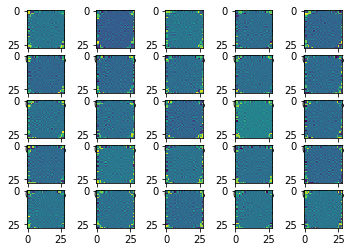

In [345]:
fig,axes=plt.subplots(5,5)
axes = axes.flatten()
for i in range(25):
    axes[i].imshow(np.reshape(W[:,i],(28,28)))


In [332]:
W.shape

(784, 25)

### ICA Using SKLearn

In [333]:
import sklearn 
from sklearn.decomposition import FastICA

In [349]:
ica = FastICA(n_components=25,whiten=True)
ica.fit(x_ica.T)

/Users/chris/Desktop/virtenv_deeprl/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
    n_components=25, random_state=None, tol=0.0001, w_init=None,
    whiten=True)

In [350]:
ica.whitening_.shape

(25, 784)

In [351]:
ica.components_.shape

(25, 784)

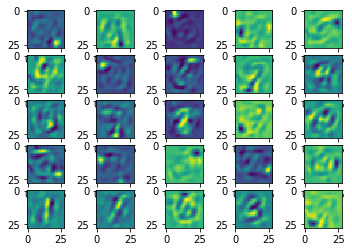

In [352]:
fig,axes=plt.subplots(5,5)
axes = axes.flatten()
for i in range(25):
    axes[i].imshow(np.reshape(ica.components_[i,:],(28,28)))


In [353]:
?FastICA

In [347]:
ica.whitening_

array([[  1.18485169e-19,   4.30855159e-20,   1.72342064e-19, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [ -2.98260710e-19,   3.97680947e-19,  -1.98840474e-19, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  2.12732358e-19,  -1.06366179e-19,  -1.72845041e-19, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  4.72937063e-19,   1.47792832e-19,   4.72937063e-19, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.20149437e-19,   3.30410952e-19,   7.20896623e-19, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [ -2.40674730e-19,  -5.71602484e-19,  -2.70759071e-19, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])